## About
The code here takes data on treated and untreated units, houses in this case, and performs propensity score matching on covariates that likely influence a unit's probability of being in the treated group. After matching and verifying adequate bias reduction, a fixed effects regression is performed to determine the average treatment effect (ATE) for the treated units compared to the matched control units.

### Note
Two files are needed to utilize this code. The first file is a cross-sectional file that contains information and covariates on the units of analysis before the treatment period. This file is used for the propensity score matching. The second file needed is a panel file that contains the variables and covariates of interest in the pre- and post-treatment period for the units of analysis. After matching, the appropriate treated and matched controls are selected from the panel set for analysis.

## Package Installation and Import

In [1]:
!pip -q install pymatch
!pip -q install linearmodels

import warnings
warnings.filterwarnings('ignore')
from pymatch.Matcher import Matcher
import pandas as pd
import numpy as np
import statistics as stat
import math
import pymatch.functions as uf
from linearmodels import PanelOLS

%matplotlib inline
import matplotlib.pyplot as plt

## Dataframe and Variable Selection

In [3]:
#data location
matchPath = "C:/Users/Anidel93/Dropbox (GaTech)/Albany Analysis/OverallStats.csv"
panelPath = "C:/Users/Anidel93/Dropbox (GaTech)/Albany Analysis/ResidentialElectricPanelData2.csv"

#reads in data from a csv file to create a DataFrame
matchDF = pd.read_csv(matchPath)
matchDF.columns = matchDF.columns.str.replace(' ', '')

panelDF = pd.read_csv(panelPath)


In [4]:
#fields that influence the matching formula
fields = \
[
    "Baseline",
    "Size",
    "Beds",
    "Baths",
    "YearBuilt",
    "Market",
    "Group",
    "Assessment"
 ]

#fields we want to pull out from the matched data to compare
fields2 = \
[
    "Project",
    "Program",
    "AddressID",
    "Index",
    "Premise"
]

#fields for panel regressions
dependent = \
[
    "NormConsumption"
]

independent = \
[
    "Post",
    "Post_Group",
    "Year_2005",
    "Year_2006",
    "Year_2007",
    "Year_2008",
    "Year_2009",
    "Year_2010",
    "Year_2011",
    "Year_2012",
    "Year_2013",
    "Year_2014",
    "Year_2015",
    "Year_2016",
    "Year_2017",
    "Year_2018",
    "Year_2019"
]

## Matching

In [5]:
#covariate data 
cov_data = matchDF[fields]
#data we will use to merge later
merge_data = matchDF[fields2]
merge_data.set_index("Index",inplace=True)

#separates data and assigns probabilities to make desired variable a binary treatment indicator
test = cov_data[cov_data.Group == 1]
control = cov_data[cov_data.Group == 0]
#in the case variable isn't already 1s and 0s, this makes the variable a binary treatment indicator
test['Group'] = 1
control['Group'] = 0


#assigns and plots propensity scores 
#prints formula used to fit logisitc regression models and the number of records in the majority/minority class
m = Matcher(test, control, yvar = 'Group', exclude=[]) 
#random number generator to make code repeatable
np.random.seed(20170925)
#setting (balance=True) ensures you are sampling from the majority group; automatically matches with replacement
m.fit_scores(balance=True, nmodels = 100) 
#prints accuracy score (R^2 coefficient of determination) which shows how well observed outcomes are replicated by model
m.predict_scores()
#m.plot_scores()

#matches data with replacement and puts the matches into a dataframe
#also exculdes data from dataset if there are no suitable matches
m.match(method="min", nmatches=2, threshold=0.0001) #|score_x - score_y| >= threshold
m.assign_weight_vector()
#compares proportional differences before and after matching as well as p-value generated from Chi-Square Test
#cc = m.compare_continuous(return_table=True) 
#print(m.matched_data)


Formula:
Group ~ Baseline+Size+Beds+Baths+YearBuilt+Market+Assessment
n majority: 19815
n minority: 307
Fitting Models on Balanced Samples: 100\100
Average Accuracy: 69.15%


Text(0.5, 1.0, 'PSM Bias Reduction')

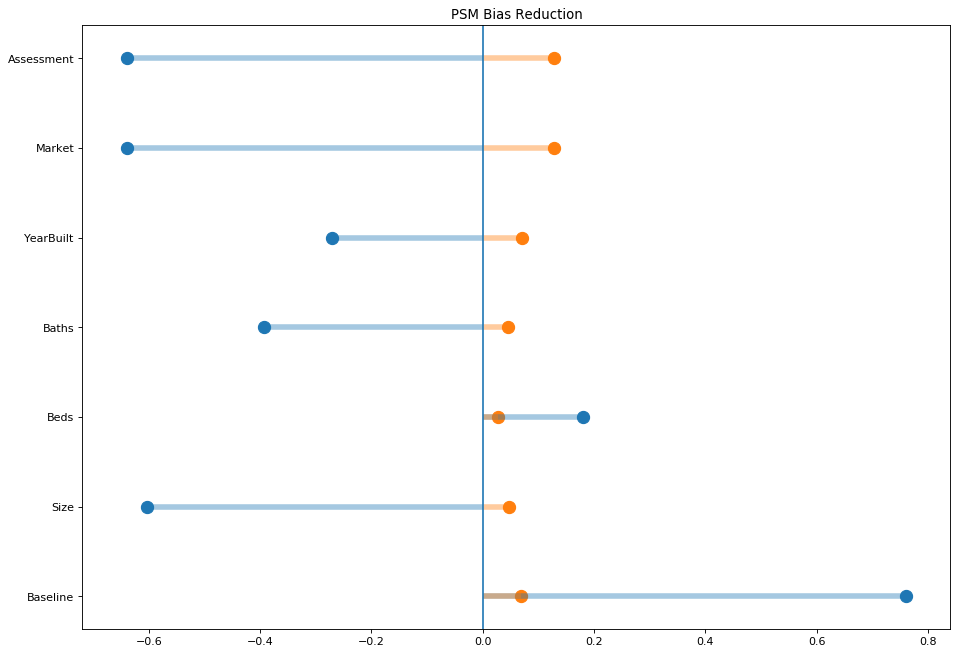

In [6]:
# Prepare Data
test_results = []
test_results_after = []
y = []
for col in m.matched_data.columns:
    if uf.is_continuous(col,m.X) and col not in m.exclude:
        # organize data
        trb, cob = m.test[col], m.control[col]
        tra = m.matched_data[m.matched_data[m.yvar]==True][col]
        coa = m.matched_data[m.matched_data[m.yvar]==False][col]
        # before/after stats
        #std_diff_med_before, std_diff_mean_before = uf.std_diff(trb, cob)
       # std_diff_med_after, std_diff_mean_after = uf.std_diff(tra, coa)
        std_diff_mean_before = (stat.mean(trb) - stat.mean(cob))/((math.sqrt(stat.variance(trb)+stat.variance(cob)))/2)
        std_diff_mean_after = (stat.mean(tra) - stat.mean(coa))/((math.sqrt(stat.variance(tra)+stat.variance(coa)))/2)
        test_results.append(std_diff_mean_before)
        test_results_after.append(std_diff_mean_after)
        y.append(col)
    

# plotting
plt.figure(figsize=(14,10), dpi= 80)
plt.hlines(y=y, xmin=0, xmax=[test_results], color=[m.control_color], alpha=0.4,linewidth=5)
plt.hlines(y=y, xmin=0, xmax=[test_results_after], color=[m.test_color],alpha=0.4,linewidth=5)
plt.scatter(test_results, y, s=120, color = m.control_color)
plt.scatter(test_results_after, y, s=120, color = m.test_color)
plt.axvline(x=0)
plt.title('PSM Bias Reduction')

## Fixed Effect Panel Regression

In [8]:
#creates csv file for desired data
matches_table = (m.matched_data.sort_values("match_id"))
matches_table['ID'] = list(range(1,matches_table.shape[0]+1))
#matches_table.set_index('ID',inplace=True)
matches_table.record_id = matches_table.record_id + 1
matches_table.rename({'record_id':'Index'},axis=1,inplace=True)
new_table = pd.merge(merge_data,matches_table,on='Index',how='right')
new_table.drop(new_table.columns[new_table.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
#matches_table.to_csv(r"/Users/Kira/Documents/ESRI_Research_Project/Matches.csv",header=True,index=True)
#new_table.to_csv(r"C:/Users/Anidel/Dropbox (GaTech)/Albany Analysis/New_Table2.csv",header=True,index=False)

#merges matched data with panel data
mergeDF = pd.merge(panelDF,new_table,on='Premise',how='right')
mergeDF.drop(mergeDF.columns[mergeDF.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
mergeDF = mergeDF.drop_duplicates(subset=['ID', 'TimePeriod'])
#mergeDF.to_csv(r"C:/Users/Anidel/Dropbox (GaTech)/Albany Analysis/New_Table.csv",header=True, index = False)


In [9]:
#Specifies individual entity and time variables
mergeDF.set_index(['ID',"TimePeriod"],inplace=True)

mergeDF['Post_Group'] = mergeDF['Post'] * mergeDF['Group']

#PanelOLS model
model = PanelOLS(mergeDF[dependent],mergeDF[independent],entity_effects=True,time_effects=False)
fit = model.fit(cov_type = 'clustered', cluster_entity=True,cluster_time=True)

print(fit)

                          PanelOLS Estimation Summary                           
Dep. Variable:        NormConsumption   R-squared:                        0.0256
Estimator:                   PanelOLS   R-squared (Between):             -0.0930
No. Observations:              163405   R-squared (Within):               0.0256
Date:                Tue, Jan 28 2020   R-squared (Overall):             -0.0720
Time:                        08:18:54   Log-likelihood                -1.108e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      250.64
Entities:                         921   P-value                           0.0000
Avg Obs:                       177.42   Distribution:               F(17,162467)
Min Obs:                       29.000                                           
Max Obs:                       186.00   F-statistic (robust):             2.6452
                            